In [1]:
import pandas as pd

# Pfad zur CSV-Datei
file_path = '../old_out.csv'

# Importieren der CSV-Datei als DataFrame
df = pd.read_csv(file_path)
df

,delta_time,symmetric_difference,nodes,rel_size,tree,alg
0,0:00:00.002001,0.000000,6,21,140643864073,Alg1
1,0:00:00.007999,0.066667,6,21,140643864073,Alg2
2,0:00:00,0.000000,10,90,140643863629,Alg1
3,0:00:00.016000,0.000000,10,90,140643863629,Alg2
4,0:00:00.001000,0.100000,5,17,140643869057,Alg1
...,...,...,...,...,...,...
195,0:00:00.003000,0.200000,5,18,140643924833,Alg2
196,0:00:00,0.000000,7,38,140643924949,Alg1
197,0:00:00.009002,0.095238,7,38,140643924949,Alg2
198,0:00:00,0.000000,5,20,140643927545,Alg1


In [2]:
del df['tree']
df

,delta_time,symmetric_difference,nodes,rel_size,alg
0,0:00:00.002001,0.000000,6,21,Alg1
1,0:00:00.007999,0.066667,6,21,Alg2
2,0:00:00,0.000000,10,90,Alg1
3,0:00:00.016000,0.000000,10,90,Alg2
4,0:00:00.001000,0.100000,5,17,Alg1
...,...,...,...,...,...
195,0:00:00.003000,0.200000,5,18,Alg2
196,0:00:00,0.000000,7,38,Alg1
197,0:00:00.009002,0.095238,7,38,Alg2
198,0:00:00,0.000000,5,20,Alg1


In [3]:
def convert_time(t):
    if len(t.split('.')) == 1:  # Mikrosekunden fehlen
        t += '.000000'  # Fügen Sie Mikrosekunden hinzu
    return pd.to_datetime(t, format='%H:%M:%S.%f').time()

df['delta_time'] = df['delta_time'].apply(convert_time)
df

,delta_time,symmetric_difference,nodes,rel_size,alg
0,00:00:00.002001,0.000000,6,21,Alg1
1,00:00:00.007999,0.066667,6,21,Alg2
2,00:00:00,0.000000,10,90,Alg1
3,00:00:00.016000,0.000000,10,90,Alg2
4,00:00:00.001000,0.100000,5,17,Alg1
...,...,...,...,...,...
195,00:00:00.003000,0.200000,5,18,Alg2
196,00:00:00,0.000000,7,38,Alg1
197,00:00:00.009002,0.095238,7,38,Alg2
198,00:00:00,0.000000,5,20,Alg1


In [4]:
def time_to_units(time_obj, time_unit):
    """ Konvertiert ein datetime.time-Objekt in die gewählte Zeiteinheit. """
    if time_unit == 'seconds':
        return time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second
    elif time_unit == 'minutes':
        return time_obj.hour * 60 + time_obj.minute + time_obj.second / 60
    elif time_unit == 'hours':
        return time_obj.hour + time_obj.minute / 60 + time_obj.second / 3600
    elif time_unit == 'milliseconds':
        return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000 + time_obj.microsecond / 1000
    elif time_unit == 'microseconds':
        return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second) * 1000000 + time_obj.microsecond

def determine_time_unit(column):
    """ Bestimmt die passende Zeiteinheit basierend auf dem Bereich der Werte in der Spalte. """
    total_seconds = column.apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second + t.microsecond / 1e6)
    max_time = total_seconds.max()
    min_time = total_seconds.min()

    if max_time - min_time < 60:  # Bereich ist weniger als 1 Minute
        if max_time - min_time < 1:  # Bereich ist weniger als 1 Sekunde
            return 'milliseconds' if max_time < 1 else 'seconds'
        return 'seconds'
    elif max_time - min_time < 3600:  # Bereich ist weniger als 1 Stunde
        return 'minutes'
    else:
        return 'hours'

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

def scatterplot_matrix(dataframe, color_column=None, plot_size=2.5, subplot_spacing=0.05):
    n_vars = dataframe.shape[1]
    fig, axes = plt.subplots(n_vars, n_vars, figsize=(n_vars * plot_size, n_vars * plot_size))

    # Umwandeln von datetime.time Spalten in numerische Werte
    num_dataframe = dataframe.copy()
    for col in num_dataframe.columns.copy():
        if isinstance(num_dataframe[col].iloc[0], datetime.time):
            time_unit = determine_time_unit(num_dataframe[col])
            num_dataframe[col] = num_dataframe[col].apply(lambda t: time_to_units(t, time_unit))
            num_dataframe = num_dataframe.rename(columns={col: f'{col}_{time_unit}'})
            
    # Farbkodierung einrichten
    if color_column is not None and color_column in num_dataframe.columns:
        unique_values = num_dataframe[color_column].unique()
        colormap = plt.cm.get_cmap('viridis', len(unique_values))
        color_dict = {val: colormap(i) for i, val in enumerate(unique_values)}
        colors = num_dataframe[color_column].map(color_dict)
    else:
        colors = 'b'

    # Erstellen der Scatterplots
    for i in range(n_vars):
        for j in range(n_vars):
            ax = axes[i, j]
            if i == j:
                ax.text(0.5, 0.5, num_dataframe.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.scatter(num_dataframe.iloc[:, j], num_dataframe.iloc[:, i], c=colors)

            # Setzen der Ticklabels
            if i != n_vars - 1:
                ax.set_xticklabels([])
            if j != 0:
                ax.set_yticklabels([])

            # Setzen der Achsenbeschriftungen
            if j == 0:
                ax.set_ylabel(num_dataframe.columns[i])
            if i == n_vars - 1:
                ax.set_xlabel(num_dataframe.columns[j])

    # Anpassen der Abstände zwischen den Subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=subplot_spacing, hspace=subplot_spacing)

    plt.show()

C:\Users\Max\AppData\Local\Temp\ipykernel_38372\2265881948.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis', len(unique_values))


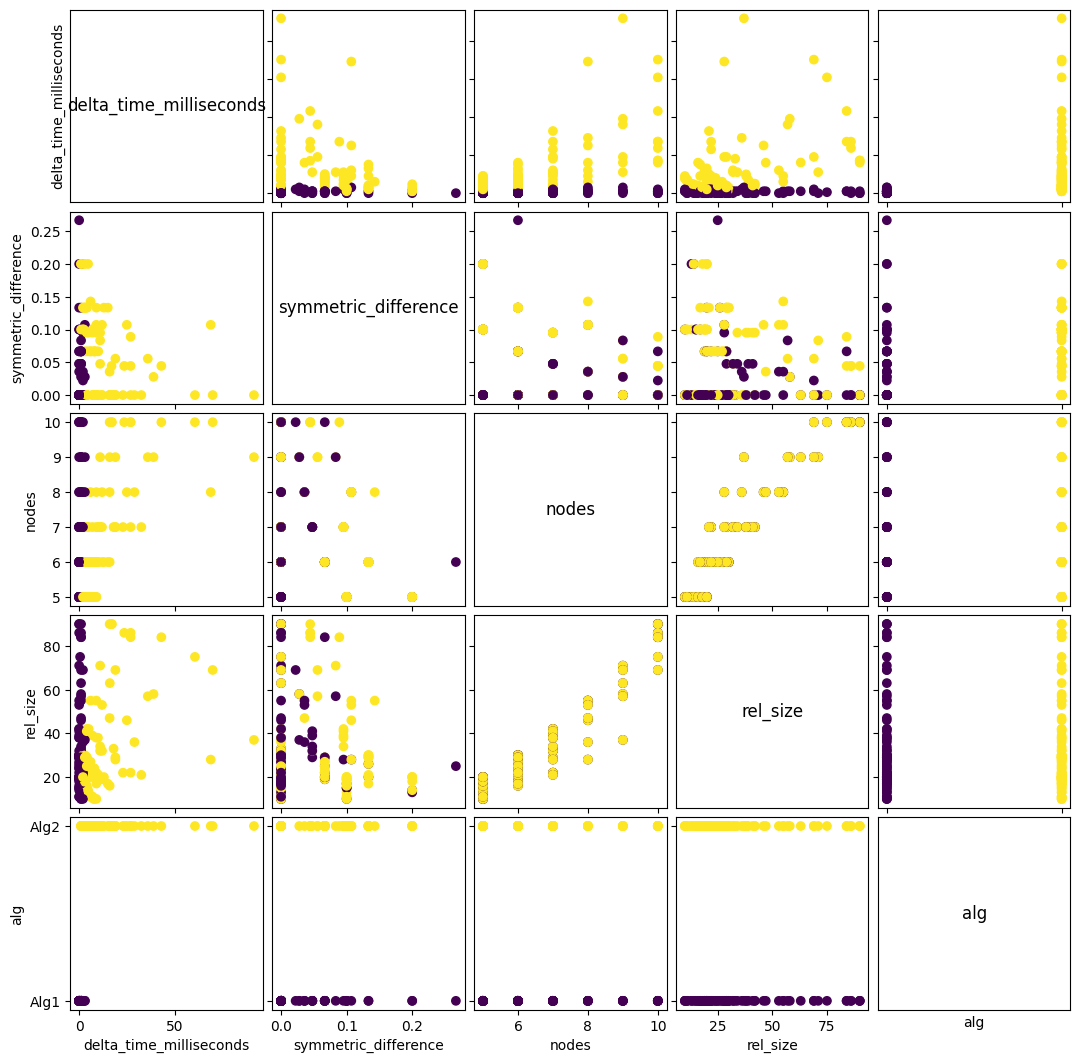

In [6]:
scatterplot_matrix(df, color_column='alg')

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime

def plot_distribution(dataframe, max_xticks=10):
    n_vars = dataframe.shape[1]
    fig, axes = plt.subplots(n_vars, 1, figsize=(8, 2 * n_vars))

    # Kopieren des DataFrames zur Umwandlung von datetime.time in numerische Werte
    num_dataframe = dataframe.copy()
    for col in num_dataframe.columns.copy():
        if isinstance(num_dataframe[col].iloc[0], datetime.time):
            time_unit = determine_time_unit(num_dataframe[col])
            num_dataframe[col] = num_dataframe[col].apply(lambda t: time_to_units(t, time_unit))
            num_dataframe = num_dataframe.rename(columns={col: f'{col}_{time_unit}'})

    for i, column in enumerate(num_dataframe.columns):
        axes[i].hist(num_dataframe[column], bins=20, edgecolor='black')
        axes[i].set_title(f'Verteilung von {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Häufigkeit')
        axes[i].xaxis.set_major_locator(MaxNLocator(max_xticks))

    plt.tight_layout()
    plt.show()


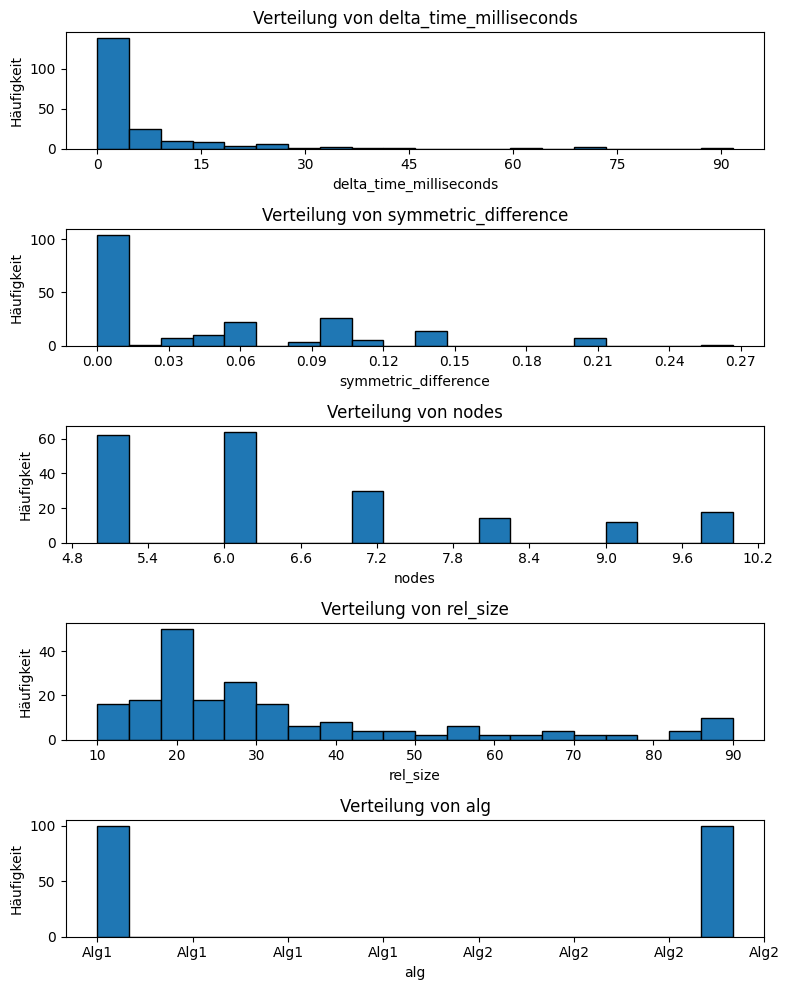

In [8]:
plot_distribution(df)